In [69]:
import numpy as np
import specsuite as ss
import matplotlib.pyplot as plt

To begin our data reduction, we need to load in several FITS files into Python. Using ```specsuite```, you can quickly load your calibration and science exposures into Numpy arrays! Here, we will be using the test data located on the GitHub repository for Apache Point Observatory's KOSMOS instrument.

In [71]:
# Defines where to look for data
DATA_REGION = (700, 800)
CAL_PATH = "../data/KOSMOS/calibrations"
DATA_PATH = "../data/KOSMOS/target"
INSTRUMENT = "kosmos"

# Collects all the necessary exposures
bias = ss.average_matching_files(
    path = CAL_PATH,
    tag = "bias",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT
)

flat = ss.average_matching_files(
    path = CAL_PATH,
    tag = "flat",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

arclamp = ss.average_matching_files(
    path = CAL_PATH,
    tag = "neon",
    crop_bds = DATA_REGION,
    instrument = INSTRUMENT,
) - bias

science = ss.collect_images_array(
    DATA_PATH,
    "toi3884",
    crop_bds=DATA_REGION,
    instrument = INSTRUMENT,
) - bias

We can also quickly display these exposures using a simplified plotting function! At its core, this is still using matplotlib, but with a handful of default arguments to ensure consistency in our visualizations.

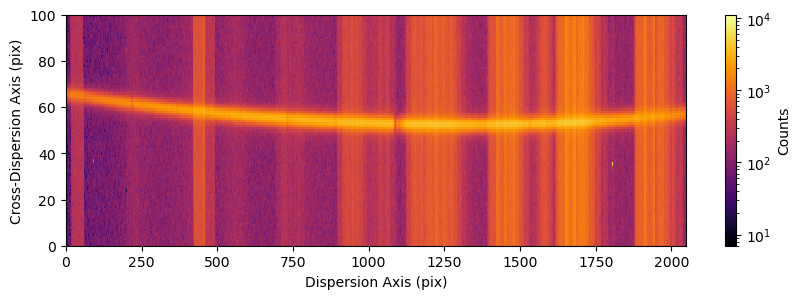

In [72]:
ss.plot_image(science[0], norm='log')

We can use our flatfield exposure to perform a standard calibration on our data!

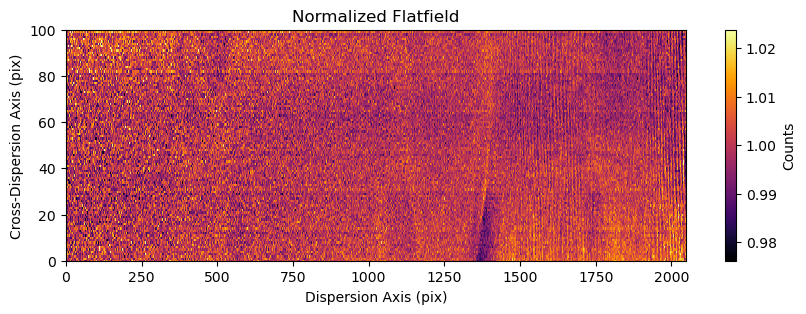

In [73]:
science = ss.flatfield_correction(
    image = science,
    flat = flat,
    debug=True,
)

Using ```specsuite```'s "warp models," we can come up with an approximate model for how light is warped on the detector.

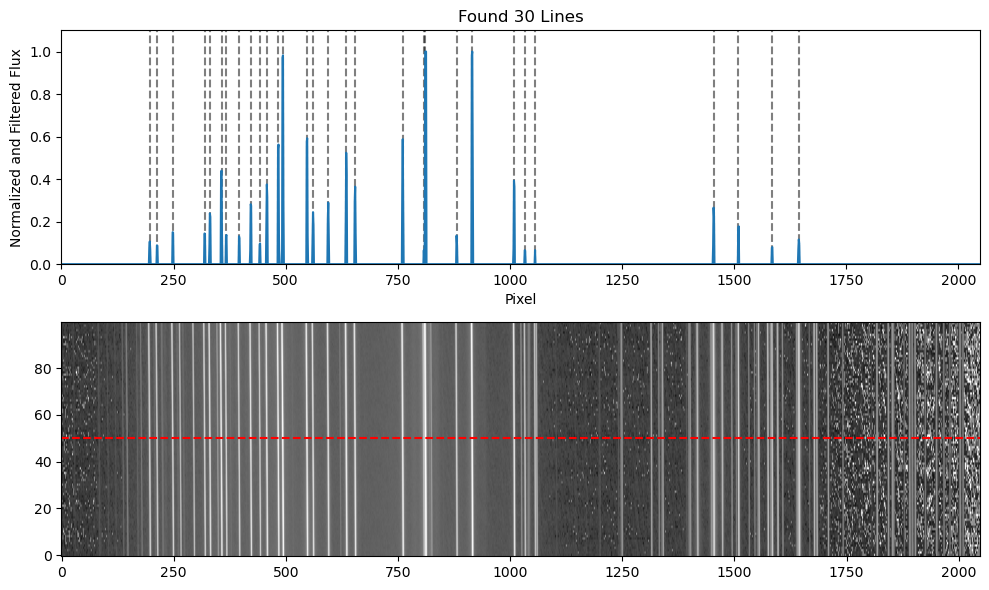

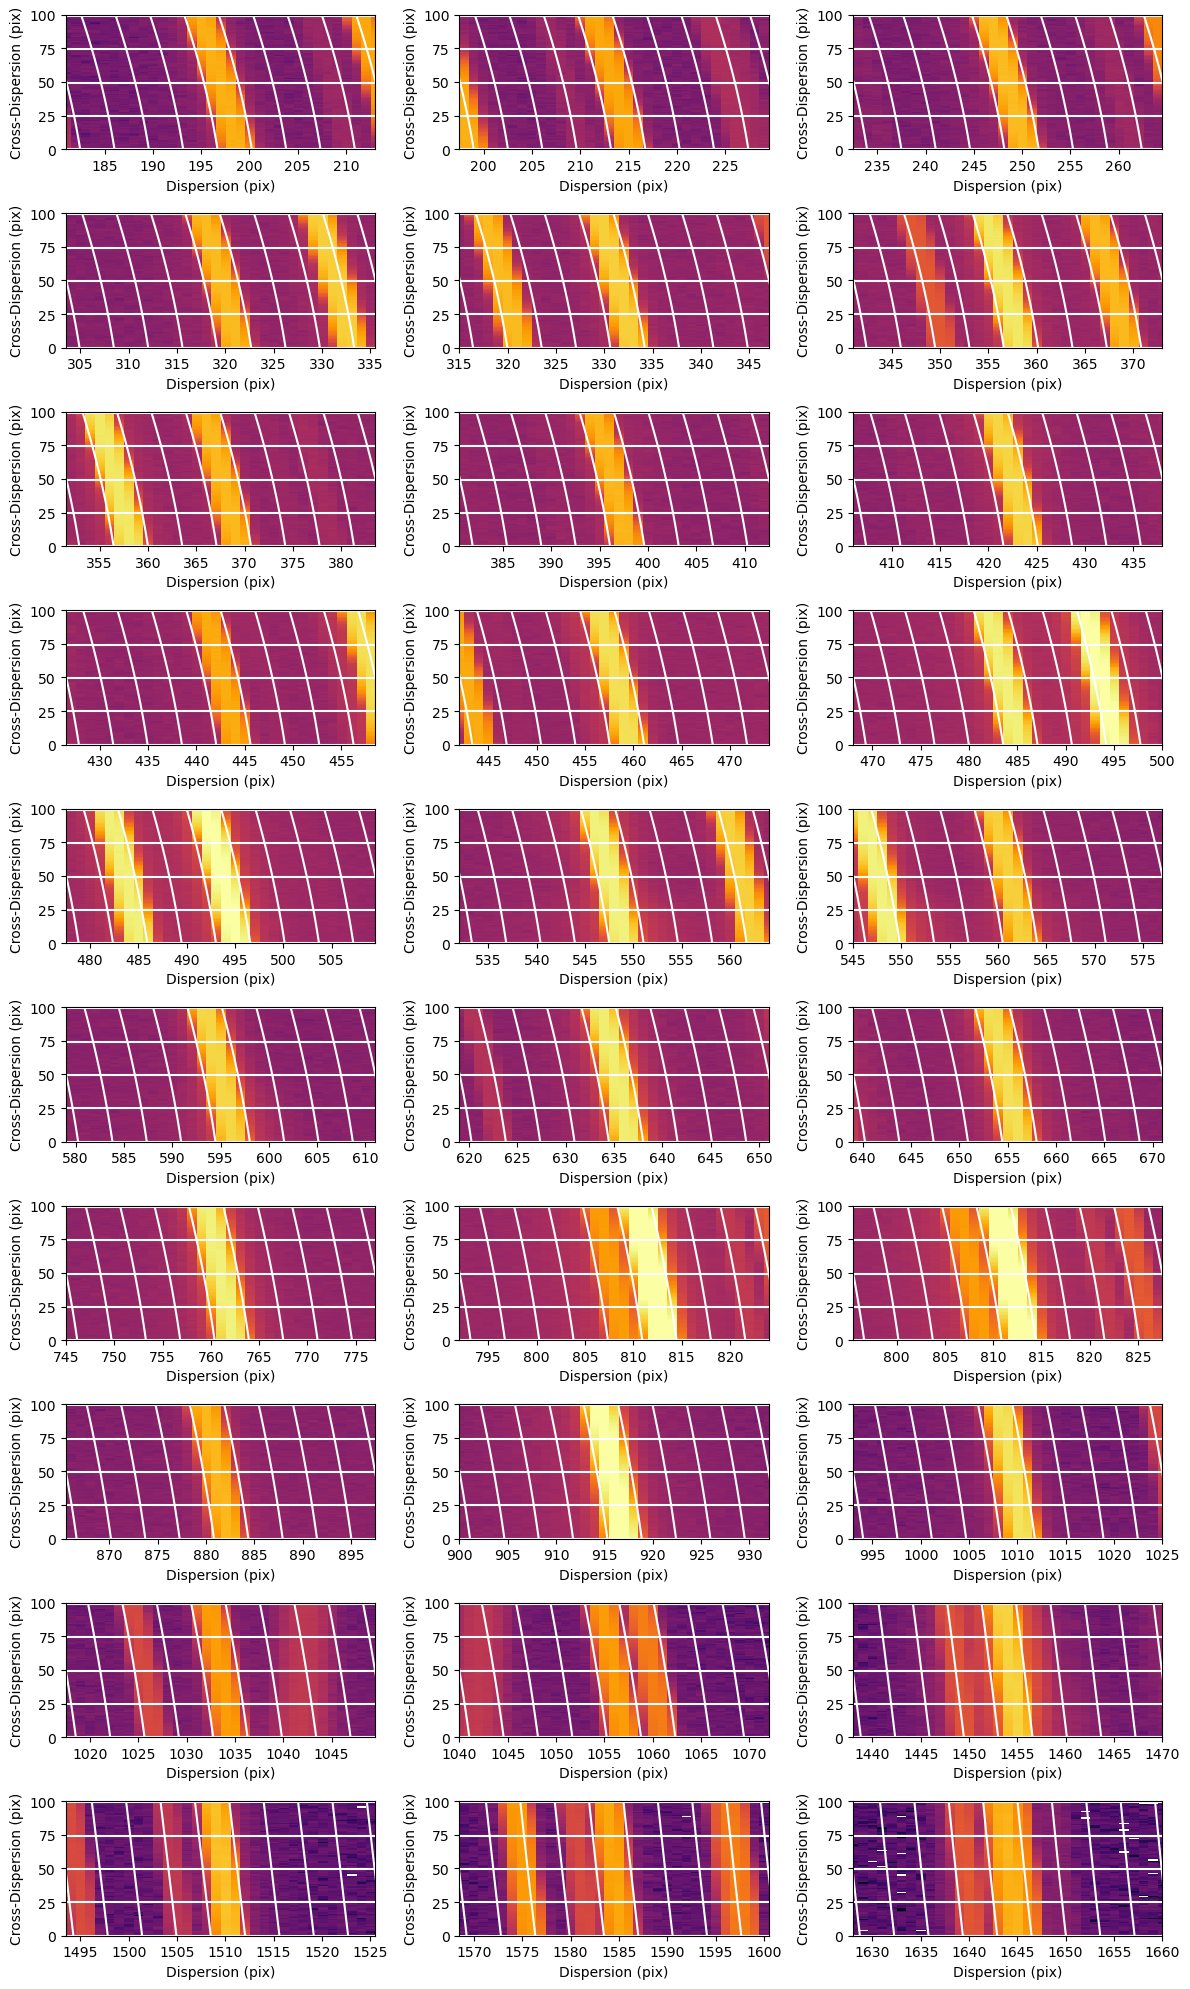

In [41]:
# Identifies the pixel positions of line emissions
locs, _ = ss.find_cal_lines(
    image = arclamp,
    std_variation = 200,
    debug=True,
)

# Models how line emissions are 'bent'
warp_model = ss.generate_warp_model(
    image = arclamp,
    guess = locs,
    debug=True,
)

This "warp model" can then be used to perform a high-quality background extraction!

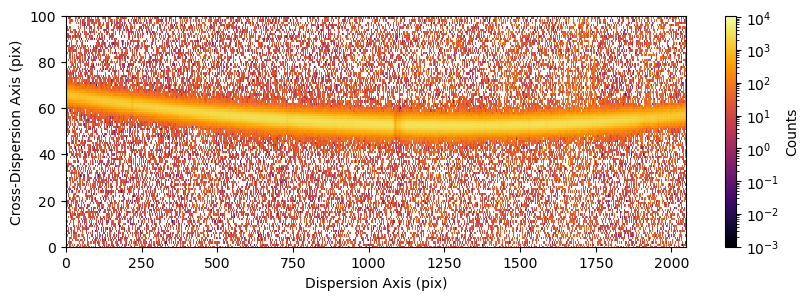

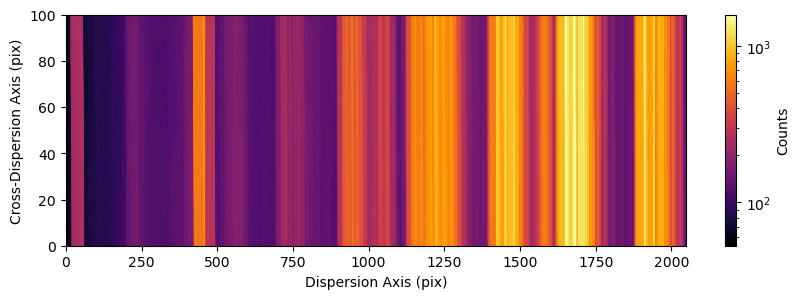

In [74]:
# The 'mask_region' is used to mask out the trace
backgrounds = ss.extract_background(
    images = science,
    warp_model = warp_model,
    mask_region = (40, 80),
)

science -= backgrounds

ss.plot_image(science[0], norm='log')
ss.plot_image(backgrounds[0], norm='log')

While there are several functions available for performing a flux extraction, we can use a simple boxcar extraction to get a quick look at our data.

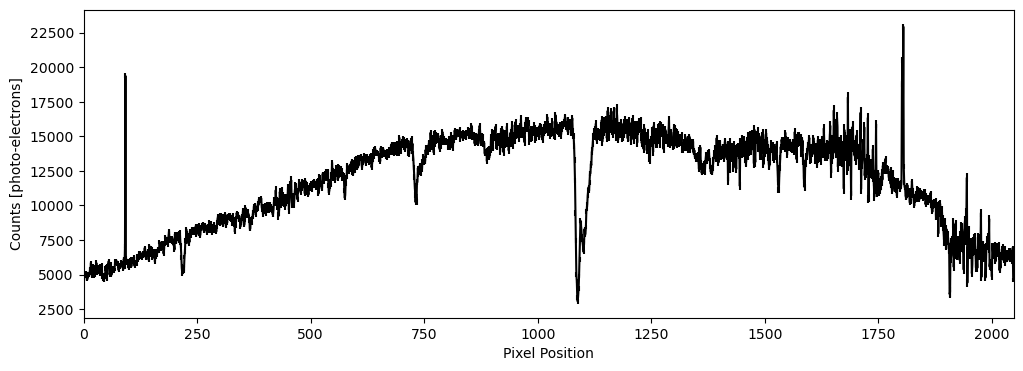

In [70]:
flux, error = ss.boxcar_extraction(
    science = science,
    backgrounds = backgrounds,
    RN = 6.0,
)

pixel_positions = np.array(range(2048))

plt.rcParams["figure.figsize"] = (12, 4)
plt.errorbar(
    pixel_positions,
    flux[0],
    yerr=error[0],
    color='k',
)
plt.xlim(0, 2048)
plt.xlabel("Pixel Position")
plt.ylabel("Counts [photo-electrons]")
plt.show()

There is more ```specsuite``` has to offer, please take a look through the documentation to get an in-depth explanation of each of these steps (+ several additional tools)!